# Classifying News Articles Using LSTM

We'll be using TorchText, which is PyTorch text library providing advanced functionalities on language processing.

The dataset we'll be using is AG News. AG News (AG’s News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus. The AG News contains 30,000 training and 1,900 test samples per class.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T

from tqdm.notebook import trange, tqdm
from NewsDataset import NewsDataset

Import the AG News Dataset

In [5]:
df_train = pd.read_csv("../../data/train.csv")
df_test = pd.read_csv("../../data/test.csv")

# Create custom NewsDataset from dataframe
dataset_train = NewsDataset(df_train)
dataset_test = NewsDataset(df_test)

Define the hyperparameters

In [6]:
learning_rate = 1e-4  # Learning rate for the optimizer
nepochs = 20  # Number of training epochs
batch_size = 32  # Batch size for training
max_len = 128  # Maximum length of input sequences

## Tokenization
Tokenization is the process of splitting a text into individual words or tokens.

Here, we use the `get_tokenizer` function from the `torchtext.data.utils` module to create a tokenizer based on the "basic_english" tokenization method.

Then we define a generator function `yield_tokens` to yield tokens from the data iterator, processing both the title and the description. From these tokens we can build the vocabulary.

In [7]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(df):
    for _, row in df.iterrows():
        yield tokenizer(row['Title'])
        yield tokenizer(row['Description'])


# Build the vocabulary from the tokens yielded by the `yield_tokens` generator function.
# We set `min_freq=2` to include a token only if it appears more than 2 times in the dataset.

# We will also add "special" tokens that we'll use to signal something to our model
# <pad> is a padding token that is added to the end of a sentence to ensure 
# the length of all sequences in a batch is the same
# <sos> signals the "Start-Of-Sentence" aka the start of the sequence
# <eos> signal the "End-Of-Sentence" aka the end of the sequence
# <unk> "unknown" token is used if a token is not contained in the vocab
vocab = build_vocab_from_iterator(
    yield_tokens(df_train),  # Tokenized data iterator
    min_freq=2,  # Minimum frequency threshold for token inclusion
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],  # Special case tokens
    special_first=True  # Place special tokens first in the vocabulary
)

# Set the default index of the vocabulary to the index of the '<unk>' token.
# If a token is not found in the vocabulary, it will be replaced with the '<unk>' token.
vocab.set_default_index(vocab['<unk>'])

Define a text transformation pipeline using TorchText Sequential Transform

In [8]:
text_tranform = T.Sequential(
    # Convert the sentences to indices based on the given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> at the beginning of each sentence. 1 is used because the index for <sos> in the vocabulary is 1.
    T.AddToken(1, begin=True),
    # Crop the sentence if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    # Add <eos> at the end of each sentence. 2 is used because the index for <eos> in the vocabulary is 2.
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor. This also pads a sentence with the <pad> token if it is shorter than the max length,
    # ensuring that all sentences are the same length.
    T.ToTensor(padding_value=0)
)

In [9]:
# Define a lambda function for tokenizing each batch of text data
text_tokenizer = lambda batch: [tokenizer(x) for x in batch]

# Create data loaders for training and testing
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)

## LSTM Model Definition

In [10]:
class LSTM(nn.Module):
    def __init__(self, num_emb, output_size, num_layers=1, hidden_size=128):
        super(LSTM, self).__init__()
        
        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.5)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_in, mem_in):
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
                
        # Pass the LSTM output through the fully connected layer to get the final output
        return self.fc_out(output), hidden_out, mem_out

## Model and Optimizer Initialization

In [11]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Define the size of the hidden layer and number of LSTM layers
hidden_size = 64
num_layers = 3

# Create the LSTM classifier model
lstm_classifier = LSTM(num_emb=len(vocab), output_size=4, 
                       num_layers=num_layers, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam optimizer
optimizer = optim.Adam(lstm_classifier.parameters(), lr=learning_rate)

# Define the loss function as CrossEntropyLoss for classification
loss_fn = nn.CrossEntropyLoss()

# Initialize lists to store training and test loss, as well as accuracy
training_loss_logger = []
test_loss_logger = []
training_acc_logger = []
test_acc_logger = []

In [12]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in lstm_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 3499844 (Approximately 3 Million) Parameters!


## Training

In [13]:
# Initialize tqdm progress bar for epochs
pbar = trange(0, nepochs, leave=False, desc="Epoch")

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in pbar:
    # Update progress bar description with current accuracy
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Test %.2f%%' % (train_acc * 100, test_acc * 100))
    
    # Set model to training mode
    lstm_classifier.train()
    steps = 0
    
    # Iterate through training data loader
    for label, text in tqdm(data_loader_train, desc="Training", leave=False):
        bs = label.shape[0]
        
        # Tokenize and transform text to tensor, move to device
        text_tokens = text_tranform(text_tokenizer(text)).to(device)
        label = (label - 1).to(device)
        
        # Initialize hidden and memory states
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        # Forward pass through the model
        pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

        # Calculate the loss
        loss = loss_fn(pred[:, -1, :], label)
            
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append training loss to logger
        training_loss_logger.append(loss.item())
        
        # Calculate training accuracy
        train_acc += (pred[:, -1, :].argmax(1) == label).sum()
        steps += bs
        
    # Calculate and append training accuracy for the epoch
    train_acc = (train_acc/steps).item()
    training_acc_logger.append(train_acc)
    
    # Set model to evaluation mode
    lstm_classifier.eval()
    steps = 0
    
    # Iterate through test data loader
    with torch.no_grad():
        for label, text in tqdm(data_loader_test, desc="Testing", leave=False):
            bs = label.shape[0]
            # Tokenize and transform text to tensor, move to device
            text_tokens = text_tranform(text_tokenizer(text)).to(device)
            label = (label - 1).to(device)

            # Initialize hidden and memory states
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            
            # Forward pass through the model
            pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            # Calculate test accuracy
            test_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs

        # Calculate and append test accuracy for the epoch
        test_acc = (test_acc/steps).item()
        test_acc_logger.append(test_acc)
        

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Testing:   0%|          | 0/238 [00:00<?, ?it/s]

## Plot Metrics

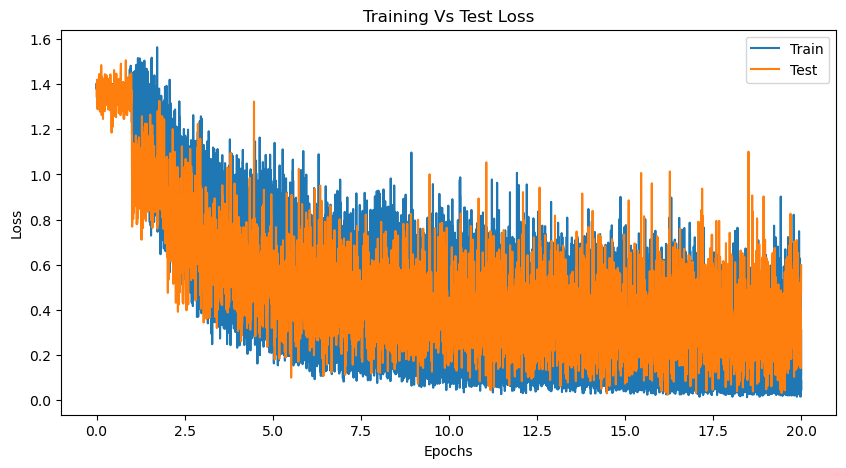

In [14]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

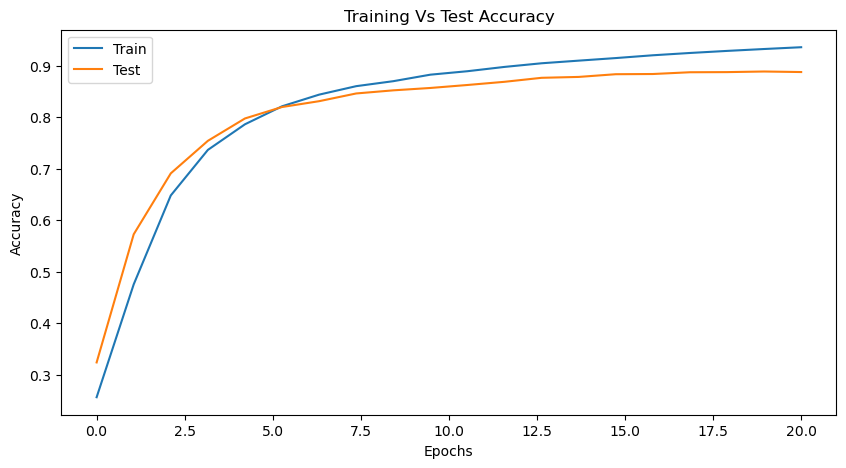

In [15]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")